# Machine Intelligence 2, SoSe 2016, Excercise Sheet 3

## The Nebenhörers:

- Danijar Hafner
- Thomas Kellermeier
- Patrick Kuhn
- Jan Szynal

In [1]:
import random
import glob
from scipy import ndimage
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Exercise 3.1

In [2]:
IMSHOW_ARGS = dict(cmap=plt.cm.gray, interpolation='nearest')

def show_patches(patches, rows, cols, title='Patches', size=10):
    assert len(patches) == rows * cols
    fig, ax = plt.subplots(
        nrows=rows, ncols=cols, figsize=(size, size / cols * rows),
        subplot_kw={'xticks': [], 'yticks': []})
    fig.suptitle(title)
    for x, y in itertools.product(range(rows), range(cols)):
        patch = patches[x * cols + y]
        ax[x, y].get_xaxis().set_visible(False)
        ax[x, y].imshow(patch, **IMSHOW_ARGS)
    plt.show()

def unpack_tiles(image, size=(10, 20)):
    grid = image.shape[0] // size[0], image.shape[1] // size[1]
    tiles = np.empty(grid + size)
    for x, y in np.ndindex(grid):
        left, top = x * size[0], y * size[1]
        tiles[x, y] = image[left: left + size[0], top: top + size[1]]
    tiles = tiles.reshape((-1, size[0] * size[1]))
    return tiles, grid

def pack_tiles(tiles, grid, size=(10, 20)):
    tiles = tiles.reshape(grid + size)
    image = np.empty((grid[0] * size[0], grid[1] * size[1]))
    for x, y in np.ndindex(grid):
        left, top = x * size[0], y * size[1]
        image[left: left + size[0], top: top + size[1]] = tiles[x, y]
    return image

def compute_pcs(data):
    cov = np.cov(data.T)
    eig, pcs = np.linalg.eig(cov)
    order = np.argsort(eig)[::-1]
    pcs, eig = pcs[order], eig[order]
    pcs = pcs.T
    return pcs, eig

def compress_tiles(tiles, pcs):
    mean = tiles.mean(axis=0)
    tiles -= mean
    transformed = np.dot(pcs, tiles.T)
    reconstructed = np.dot(pcs.T, transformed).T
    reconstructed += mean
    return reconstructed

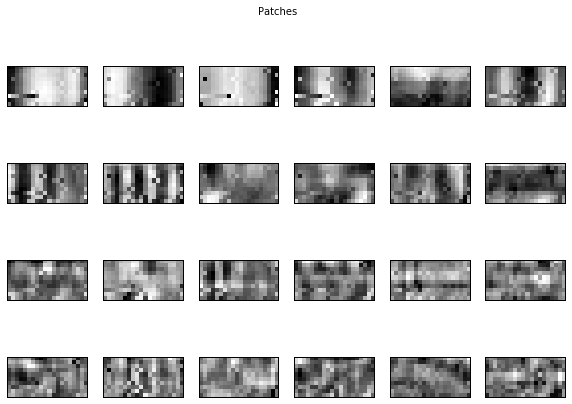

In [3]:
size = (10, 20)
patch = np.s_[:200, :200]
# b8
tiles, grid = unpack_tiles(ndimage.imread('imgpca/t11.jpg')[patch], size)
pcs, eig = compute_pcs(tiles)

show_patches(pcs.reshape((-1,) + size)[:24], 4, 6)

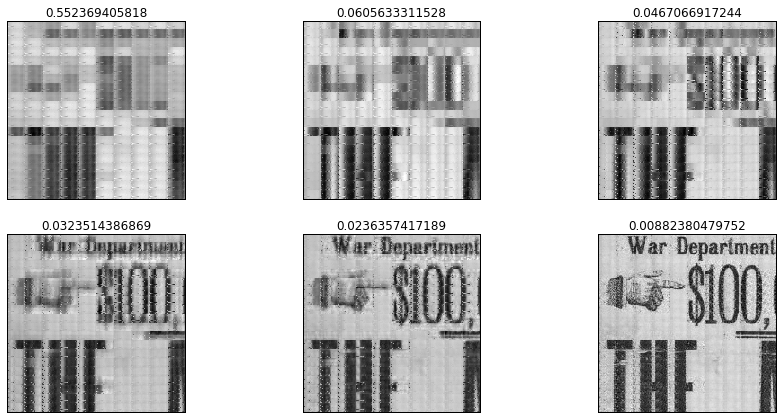

In [4]:
def compress(tiles, pcs, grid, size):
    fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})
    for index, resolution in enumerate([1, 2, 4, 8, 16, 100]):
        compressed = compress_tiles(tiles, pcs[:resolution])
        ax_index = index // 3, index % 3
        ax[ax_index].set_title(np.power(compressed - tiles, 2).mean() / (256 * size[0] * size[1]))
        ax[ax_index].imshow(pack_tiles(compressed, grid, size), **IMSHOW_ARGS)
    plt.show()

compress(tiles, pcs, grid, size)

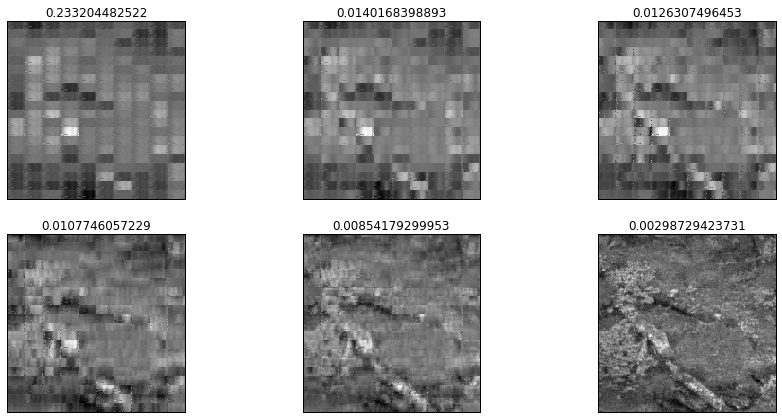

In [5]:
other, other_grid = unpack_tiles(ndimage.imread('imgpca/n1.jpg')[patch], size)
compress(other, pcs, other_grid, size)

## Exercise 3.2

Expanding the Taylor Series centred at zero (Maclaurin series) leads to the function

$$
w_i(t + 1)  = f(0) + \eta f'(0) + \frac{1}{2} * \eta ^ 2 * f''(0)
$$

Since all terms which include a factor of $\eta^2$ can be neglected only the first two terms are needed.

### Calculating $f(0)$

$$
f(0) = \frac{w_i(t)}{\sum_{j = 1}^{N} (w_j(t) ^ 2) ^ {1/2}}
$$

Since the length of the weight vector is one 

$$
\sum_{j = 1}^{N} (w_j(t) ^ 2) ^ {1/2} = 1 \implies f(0) = w_i(t)
$$

### Calculating $f'(0)$

Quotient rule:

$$
f(\frac{u}{v})' = \frac{u' * v - v' * u}{v^2} = \frac{u' * v }{v^2} - \frac{u * v' }{v^2}\\
$$

### Ojas rule

$$
w_i(t + 1) = \frac{w_i + \eta * y(x) * x_i}
{(\sum_{j = 1}^{N} [w_j(t) + \eta * y(t) * x_j(t)] ^ 2 ) ^ {1/2} }
$$

$$
u = w_i + \eta * y(t) * x_i \\ 
u' = y(t) * x_i \\
$$

$$
v = (\sum_{j = 1}^{N} [w_j(t) + \eta * y(t) * x_j(t)] ^ 2 ) ^ {1/2} \\
v^2 = \sum_{j = 1}^{N} [w_j(t) + \eta * y(t) * x_j(t)] ^ 2
$$

### Calculating v' by applying chain rule twice

$$
v' = \frac{1}{2} * \frac{1}{\sum_{j = 1}^{N} [w_j(t) + \eta * y(t) * x_j(t)] ^ 2} * 2 * (\sum_{j = 1}^{N} w_j(t) + \eta * y(t) * x_j(t)) * y(t) * x_i(t) \\
$$

$$
v' = \frac{(\sum_{j = 1}^{N} w_j(t) + \eta * y(t) * x_j(t)) * y(t) * x_i(t)}{(\sum_{j = 1}^{N} [w_j(t) + \eta * y(t) * x_j(t)] ^ 2) ^ {1/2}}
$$

$$
f'(\eta) = \frac{y(x) * x_i(t) * \sum_{j = 1}^{N} [w_j(t) + \eta * y(t) * x_j(t)] ^ 2 ) ^ {1/2}}{\sum_{j = 1}^{N} [w_j(t) + \eta * y(t) * x_j(t)] ^ 2} - \frac{\frac{(\sum_{j = 1}^{N} w_j(t) + \eta * y(t) * x_j(t)) * y(t) * x_i(t)}{(\sum_{j = 1}^{N} [w_j(t) + \eta * y(t) * x_j(t)] ^ 2) ^ {1/2}} * (w_i(t) + \eta * y(x) * x_i(t) )}{\sum_{j = 1}^{N} [w_j(t) + \eta * y(t) * x_j(t)] ^ 2}
$$

$$
f'(\eta) = \frac{y(x) * x_i(t) }{(\sum_{j = 1}^{N} [w_j(t) + \eta * y(t) * x_j(t)] ^ 2) ^ {1/2}} - \frac{(\sum_{j = 1}^{N} w_j(t) + \eta * y(t) * x_j(t)) * y(t) * x_i(t) * (w_i(t) + \eta * y(x) * x_i)}{\sum_{j = 1}^{N} [w_j(t) + \eta * y(t) * x_j(t)] ^ {3/2}}
$$

$$
f'(0) = \frac{y(x) * x_i(t) }{(\sum_{j = 1}^{N} [w_j(t)] ^ 2) ^ {1/2}} - \frac{(\sum_{j = 1}^{N} w_j(t) * x_j(t)) * y(t)  * w_i(t)}{\sum_{j = 1}^{N} [w_j(t)] ^ {3/2}}
$$

Since the length of the weight vector equals 1:

$$
f'(0) = y(t) * x_i(t) - (\sum_{j = 1}^{N} w_j(t) * x_j(t)) * y(t)  * w_i(t)
$$

Since $\sum_{j = 1}^{N} w_j(t) * x_j(t) = y(t)$

$$
f'(0) = y(t) * x_i(t) - y(t) * y(t)  * w_i(t)
$$

### Inserting in initial equation

$$
w_i(t + 1) = w_i(t) + \eta * (y(t) * x_i(t) - y(t) * y(t) * w_i(t)) \\
w_i(t + 1) = w_i(t) + \eta * y(t) * (x_i(t) - y(t) * w_i(t))
$$

## Exercise 3.3

In [61]:
data = pd.read_csv('data-onlinePCA.txt', index_col=0).as_matrix()

def create_time_scatter(steps, ncols, title):
    fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(12, 18 / ncols))
    fig.suptitle(title, fontsize=20, y=1.15)
    timesteps = np.linspace(0, 1, steps)
    for col in range(ncols):
        ax[1, col].imshow(np.vstack((timesteps, timesteps)), cmap=plt.cm.rainbow, aspect=50)
        ax[1, col].axes.get_yaxis().set_ticks([])
    for x in ax[0]:
        x.set_aspect('equal', 'box')
    fig.tight_layout();
    return ax[0]

def plot_pca_arrow(ax, data, length=3.0, **kwargs):
    pcs, _ = compute_pcs(data)
    pc = pcs[0] * length
    options = dict(head_width=0.3, head_length=0.3, fc='k', ec='k')
    options.update(kwargs)
    ax.arrow(0, 0, pc[0], pc[1], **options)
    ax.arrow(0, 0, -pc[0], -pc[1], **options)
    
def plot_series(ax, data, **kwargs):
    timesteps = np.linspace(0, 1, len(data))
    colors = plt.cm.rainbow(timesteps)
    ax.scatter(data[:, 0], data[:, 1], color=colors, **kwargs)

Implement Oja’s rule and apply it with a learning-rate parameter η ∈ {0.002, 0.04, 0.45}
to the dataset. 

Plot the weights at each timestep (as points whose x vs. y coordinates are
given by the weight for x and y) in the same plot as the original data (use the colors from
1 to indicate the time index for each plotted weight). 

Interpret your results.

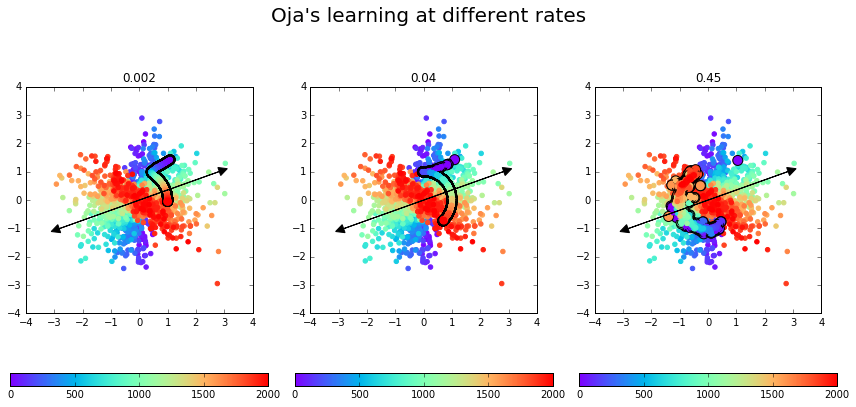

In [62]:
learning_rates = [0.002, 0.04, 0.45]

def ojas_rule(data, initial_w, learning_rate):
    w = initial_w.copy()
    for x in data:
        y = np.dot(w.T, x)
        w += learning_rate * y * (x - y * w)
        yield w.copy()

ax = create_time_scatter(len(data), len(learning_rates), "Oja's learning at different rates")
initial_w = 2.0 * np.random.RandomState(0).rand(2)
# Normalize initial weights to skip initial learning phase. But it's kind of interesting so we
# have this commented out.
# initial_w /= np.linalg.norm(initial_w)
for index, learning_rate in enumerate(learning_rates):
    weights = np.array(list(ojas_rule(data, initial_w, learning_rate)))
    ax[index].set_title(learning_rate)
    plot_series(ax[index], data)
    plot_series(ax[index], weights, edgecolor='k', s=100)
    plot_series(ax[index], weights)
    plot_pca_arrow(ax[index], data)
plt.show()